In [1]:
! pip install utm
! pip install geopandas


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import utm
from shapely.geometry import Point

## Segmentação de restaurantes com KMeans
### Importando Biliotecas

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as shc

from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_csv('df_operating_hours.csv',sep=',')
df

,title,place_id,sunday,monday,tuesday,wednesday,thursday,friday,saturday
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,Closed,8 am–8 pm,8 am–8 pm,8 am–8 pm,8 am–8 pm,8 am–8 pm,8 am–8 pm
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,Closed,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,Closed,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,Closed,11 am–3 pm,11 am–3 pm,11 am–3 pm,11 am–3 pm,11 am–3 pm,Closed
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,Closed,11 am–10 pm,11 am–10 pm,11 am–10 pm,11 am–10 pm,11 am–10 pm,11 am–10 pm
...,...,...,...,...,...,...,...,...,...
9995,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,1 pm–12 am,11:30 am–10 pm,11:30 am–10 pm,11:30 am–10 pm,11:30 am–10 pm,1 pm–12 am,1 pm–12 am
9996,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,7 pm–12 am,Closed,7 pm–12 am,7 pm–12 am,7 pm–12 am,7 pm–12 am,7 pm–12 am
9997,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,2–10 pm,Closed,Closed,6 pm–12 am,6 pm–12 am,6 pm–12 am,2 pm–12 am
9998,O Pingado,ChIJb70UCdlXzpQRsqTkBxeES1o,Closed,Closed,6:30–11:30 pm,6:30–11:30 pm,6:30–11:30 pm,6:30–11:30 pm,6:30–11:30 pm


### Data Prep
#### Feature engineering para tratamento de dados com horário de funcionamento

In [7]:
def to_float(txt):
  '''
  transforma a string de horario em float. ex: 8:30pm -> 20.5 / 9am -> 9.0
  '''
  txt = txt.lower()
  if re.search('am', txt) == None:
    txt = re.sub('(pm *)', '', txt)
    txt = separa_hora_minuto(txt)
    txt = int(txt[0])+12+(int(txt[1])*(10/6)/100)
  else:
    txt = re.sub('(am *)', '', txt)
    txt = separa_hora_minuto(txt)
    txt = int(txt[0])+(int(txt[1])*(10/6)/100)
  return float(txt) if float(txt) >= 1 else float(txt)+24

def separa_hora_minuto(txt):
  '''
  separação simples do horário e minuto.
  Aqui também o 12 é transformado em 0, para caber na nossa logica de relogio de 12h para relogio de 24h
  '''
  txt = txt.split(':')
  if int(txt[0]) == 12:
    txt[0] = 0
  if len(txt) == 1:
    txt.append('0')
  return txt

def definindo_inicio_fim(df):
  '''
  recebe um daframe com os horarios de funcionamento de cada dia e centraliza em apenas suas colunas o horario de abertura/fechamento.
  O dia escolhido para representar o horario de funcionamento majoritário é o primeiro que não estja fechado
  de acorodo com a ordem da lista 'dias_da_semana' (quase todos os restaurantes utilizam a sexta)
  '''
  dias_da_semana = [ 'friday', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday']
  for index, row in df.iterrows():
    for d in dias_da_semana:
      try:
        df.loc[index, 'inicio'] = to_float(row[d].split('–')[0])
        df.loc[index, 'fim'] = to_float(row[d].split('–')[1])
        break
      except:
        pass
  return df
def dias_aberto(df):
  '''
  Recebe dataframe com horario de funcionamento dos dias da semana e simplifica para apenas a infromação de se abre ou não em cada um dos dias
  '''
  # considerei sexta como final de semana
  dias_de_semana = [ 'monday', 'tuesday', 'wednesday', 'thursday']
  dias_final_de_semana = [ 'friday', 'saturday', 'sunday']

  for index, row in df.iterrows():
    aberto_fds = 0
    aberto_semana = 0
    for d in dias_de_semana:
      if str(row[d]).lower() == 'closed':
         df.loc[index, d] = 'Closed'
      else:
        df.loc[index, d] = 'Open'
        aberto_semana += 1
    for d in dias_final_de_semana:
      if str(row[d]).lower() == 'closed':
         df.loc[index, d] = 'Closed'
      else:
        df.loc[index, d] = 'Open'
        aberto_fds += 1
      df.loc[index, 'aberto_dia_util(%)'] = round(aberto_semana/len(dias_de_semana)*100,1)
      df.loc[index, 'aberto_final_de_semana(%)'] = round(aberto_fds/len(dias_final_de_semana)*100,1)
  return df
def porcentagem_por_periodo(inicio, fim, periodos):
  '''
  Verifica quantas horas cada restaurante fica aberto em cada peridodo.
  Para normalizar os dados, esses numero são transformados em porcentagem. ex: um restaurante que fica aberto das 6-20h fica aberto 100% do horário da manha (pois o periodo da
  manha vai das 6 às 12h), ou seja, a manha inteira (100%).
  '''
  aberto_periodo = dict()
  for p in periodos:
    inicio_periodo = periodos[p][0]
    fim_periodo = periodos[p][1]
    total_periodo = fim_periodo - inicio_periodo
    if inicio <= fim_periodo and fim >= inicio_periodo:
      aberto_periodo[p] = round((min(fim, fim_periodo) - max(inicio, inicio_periodo))/total_periodo*100,0)
    else:
      aberto_periodo[p] = 0
  
  return aberto_periodo.values()

In [8]:
df

,title,place_id,sunday,monday,tuesday,wednesday,thursday,friday,saturday
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,Closed,8 am–8 pm,8 am–8 pm,8 am–8 pm,8 am–8 pm,8 am–8 pm,8 am–8 pm
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,Closed,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm,11:30 am–2:30 pm
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,Closed,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm,11 am–2:30 pm
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,Closed,11 am–3 pm,11 am–3 pm,11 am–3 pm,11 am–3 pm,11 am–3 pm,Closed
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,Closed,11 am–10 pm,11 am–10 pm,11 am–10 pm,11 am–10 pm,11 am–10 pm,11 am–10 pm
...,...,...,...,...,...,...,...,...,...
9995,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,1 pm–12 am,11:30 am–10 pm,11:30 am–10 pm,11:30 am–10 pm,11:30 am–10 pm,1 pm–12 am,1 pm–12 am
9996,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,7 pm–12 am,Closed,7 pm–12 am,7 pm–12 am,7 pm–12 am,7 pm–12 am,7 pm–12 am
9997,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,2–10 pm,Closed,Closed,6 pm–12 am,6 pm–12 am,6 pm–12 am,2 pm–12 am
9998,O Pingado,ChIJb70UCdlXzpQRsqTkBxeES1o,Closed,Closed,6:30–11:30 pm,6:30–11:30 pm,6:30–11:30 pm,6:30–11:30 pm,6:30–11:30 pm


In [9]:
def funcionamento_por_periodo(df, periodos):
  '''
  atribui ao dataframe colunas que traduzem qual porcentagem de horas de cada periodo eles ficam abertos.
  ex: um restaurante que fica aberto das 6-20h fica aberto 100% dos horários da manha (pois o pedio da
   manha vai das 6 às 12h), ou seja, a manha inteira.
  '''

  for index, row in df.iterrows():
    inicio = row['inicio']
    fim = row['fim']
    if fim < inicio:
      # em alguns casos o horario de funcionamento de determinado dia indicava o que parecia ser
      # a manhã do dia seguinte ex: 11am às 10am. com esse tratamento limitamos como limite de funcionamento de um determiando dia
      # a sua última hora (24h -> meia noite)
      fim = 24
    df.loc[index, list(periodos.keys())] = porcentagem_por_periodo(inicio, fim, periodos)
  
  return df
def definir_inicio_fim_periodo(df, periodos):
  '''
  retorna colunas que indicam em que periodo o restaurante abre/fecha
  '''
  for index, row in df.iterrows():
    inicio = row['inicio']
    fim = row['fim']
    for p in periodos:
        inicio_periodo = periodos[p][0]
        fim_periodo = periodos[p][1]
        if inicio <= fim_periodo and inicio >= inicio_periodo:
          df.loc[index, 'inicio_periodo'] = p
          break
    for p in periodos:
        inicio_periodo = periodos[p][0]
        fim_periodo = periodos[p][1]
        if fim <= fim_periodo and fim >= inicio_periodo:
            df.loc[index, 'fim_periodo'] = p
            break
    
  return df

In [10]:
# add colunas como horario de abertura e fechamento (explicacao mais detalhada na funcao)
df = definindo_inicio_fim(df)

# Convertendo horarios de abertura por dia para se abre ou não aquele dia
df = dias_aberto(df)

In [11]:
madrugada = [1, 5.9]
manha = [6, 11.9]
tarde = [12, 18.9]
noite = [19, 24.9]

periodos = {
    'madrugada': madrugada, 
    'manha': manha, 
    'tarde': tarde, 
    'noite': noite
}

In [12]:
# adicionando colunas que indicam quantos % de cada período o restaurante está aberto
#  ex: um restaurante que fica aberto das 6-20h fica aberto 100% do horário da manha (pois o periodo da
# manha vai das 6 às 12h), ou seja, a manha inteira (100%).
df = funcionamento_por_periodo(df, periodos)
df

,title,place_id,sunday,monday,tuesday,wednesday,thursday,friday,saturday,inicio,fim,aberto_dia_util(%),aberto_final_de_semana(%),madrugada,manha,tarde,noite
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,Closed,Open,Open,Open,Open,Open,Open,8.0,20.0,100.0,66.7,0.0,66.0,100.0,17.0
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,Closed,Open,Open,Open,Open,Open,Open,11.5,14.5,100.0,66.7,0.0,7.0,36.0,0.0
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,Closed,Open,Open,Open,Open,Open,Open,11.0,14.5,100.0,66.7,0.0,15.0,36.0,0.0
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,Closed,Open,Open,Open,Open,Open,Closed,11.0,15.0,100.0,33.3,0.0,15.0,43.0,0.0
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,Closed,Open,Open,Open,Open,Open,Open,11.0,22.0,100.0,66.7,0.0,15.0,100.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,Open,Open,Open,Open,Open,Open,Open,13.0,24.0,100.0,100.0,0.0,0.0,86.0,85.0
9996,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,Open,Closed,Open,Open,Open,Open,Open,19.0,24.0,75.0,100.0,0.0,0.0,0.0,85.0
9997,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,Open,Closed,Closed,Open,Open,Open,Open,18.0,24.0,50.0,100.0,0.0,0.0,13.0,85.0
9998,O Pingado,ChIJb70UCdlXzpQRsqTkBxeES1o,Closed,Closed,Open,Open,Open,Open,Open,18.5,23.5,75.0,66.7,0.0,0.0,6.0,76.0


In [13]:
df = definir_inicio_fim_periodo(df, periodos)
df

,title,place_id,sunday,monday,tuesday,wednesday,thursday,friday,saturday,inicio,fim,aberto_dia_util(%),aberto_final_de_semana(%),madrugada,manha,tarde,noite,inicio_periodo,fim_periodo
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,Closed,Open,Open,Open,Open,Open,Open,8.0,20.0,100.0,66.7,0.0,66.0,100.0,17.0,manha,noite
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,Closed,Open,Open,Open,Open,Open,Open,11.5,14.5,100.0,66.7,0.0,7.0,36.0,0.0,manha,tarde
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,Closed,Open,Open,Open,Open,Open,Open,11.0,14.5,100.0,66.7,0.0,15.0,36.0,0.0,manha,tarde
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,Closed,Open,Open,Open,Open,Open,Closed,11.0,15.0,100.0,33.3,0.0,15.0,43.0,0.0,manha,tarde
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,Closed,Open,Open,Open,Open,Open,Open,11.0,22.0,100.0,66.7,0.0,15.0,100.0,51.0,manha,noite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,Open,Open,Open,Open,Open,Open,Open,13.0,24.0,100.0,100.0,0.0,0.0,86.0,85.0,tarde,noite
9996,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,Open,Closed,Open,Open,Open,Open,Open,19.0,24.0,75.0,100.0,0.0,0.0,0.0,85.0,noite,noite
9997,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,Open,Closed,Closed,Open,Open,Open,Open,18.0,24.0,50.0,100.0,0.0,0.0,13.0,85.0,tarde,noite
9998,O Pingado,ChIJb70UCdlXzpQRsqTkBxeES1o,Closed,Closed,Open,Open,Open,Open,Open,18.5,23.5,75.0,66.7,0.0,0.0,6.0,76.0,tarde,noite


In [14]:
df['inicio_periodo'] = df['inicio_periodo'].replace(['cedo_noite'], 'noite')
df['inicio_periodo'] = df['inicio_periodo'].replace(['tarde_noite'], 'noite')

In [15]:
df['inicio_periodo'].value_counts()

manha        5717
tarde        3035
noite         477
madrugada      96
Name: inicio_periodo, dtype: int64

In [16]:
df['fim_periodo'].value_counts()

noite        5095
tarde        2996
madrugada    1093
manha         115
Name: fim_periodo, dtype: int64

In [17]:
df2 = pd.read_csv('df_overview.csv',sep=',',index_col=0)
df2

,title,place_id,data_id,data_cid,rating,reviews,price,type,address,latitude,longitude,open_state,description,thumbnail
position,,,,,,,,,,,,,,
1,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,0x94ce5393313c4d53:0xb45e97dbf6c3aa6,812312034101967526,4.6,14.0,NaN,Restaurant,"Estr. do Campo Limpo, 992 - Vila Prel, São Pau...",-23.647919,-46.762998,Open ⋅ Closes 8 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipO1TL...
2,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,0x94ce5e6585b58553:0xd940c7253819b56f,15654731267408770415,4.6,17.0,NaN,Restaurant,"Rua Coronel Marques, 399 - Vila Nova Mancheste...",-23.543091,-46.545526,Opens soon ⋅ 11:30 am,NaN,https://streetviewpixels-pa.googleapis.com/v1/...
3,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,0x94c58a8e0adfb785:0x46f3aeddca51bd11,5112622269601004817,4.5,881.0,£,Buffet restaurant,"Av. Prof. Arthur Fonseca, 841 - Jardim Faculda...",-23.515907,-47.463541,Open ⋅ Closes 2:30 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipP11R...
4,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,0x94cef8ee5c12f5cd:0xeff7c9551c8c1587,17291510661700654471,4.5,201.0,NaN,Buffet restaurant,"R. Conselheiro Ribas, 330 - Vila Anastácio, Sã...",-23.514702,-46.720743,Closed ⋅ Opens 11 am Mon,NaN,https://lh5.googleusercontent.com/p/AF1QipOzyq...
5,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,0x94ce56ecb93b9a47:0xf86e7281c3fed2e0,17901371470508905184,4.5,26.0,NaN,Restaurant,"Rua Dr. SÍlvio Dante Bertacchi, 253 - Vila Son...",-23.596165,-46.729929,Open ⋅ Closes 10 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipMMLu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,0x94cef9fe0d4c3d53:0x622b590496b702e8,7073845515958813416,4.8,35.0,NaN,Restaurant,"R. Antônio da Cunha Coelho, 190 - Freguesia do...",-23.494646,-46.708050,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipNqh7...
6,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,0x94ce4f5c78a8574b:0x2b99509d0030ecd0,3141630850310925520,NaN,NaN,NaN,Bar,"R. Dr. Domingos Freire, 106 - Parque Itaberaba...",-23.478881,-46.678635,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipPlef...
10,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,0x94ce5933e45f8771:0x9e976d2c23af8e97,11427722615820619415,4.6,512.0,$$,Bar,"R. Sousa Lima, 174 - Barra Funda, São Paulo - ...",-23.529198,-46.654336,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipMnVr...


In [19]:
df3 = pd.read_csv('df_service_options.csv',sep=',')
df3

,title,place_id,dine_in,takeout,delivery,drive_through
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,True,True,False,False
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,True,True,True,False
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,True,True,False,False
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,True,True,True,False
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,True,True,False,False
...,...,...,...,...,...,...
9995,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,True,True,False,False
9996,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,True,True,True,False
9997,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,True,True,False,False
9998,O Pingado,ChIJb70UCdlXzpQRsqTkBxeES1o,True,False,False,False


#### Juntando as 3 bases pela chave `place_id`(Nome do estabelecimento)

In [20]:
df4 = df2.merge(df, how='left', on='place_id')
df5 = df4.merge(df3, how='left', on='place_id')
df5 = df5.drop_duplicates(subset='place_id')

#### Tratando os tipos dos restaurantes

In [22]:
#Fazer data prep ed tipos de restaurantes
df5['type'].value_counts()

Restaurant                 1861
Bar                         503
Pizza restaurant            491
Snack bar                   416
Fast food restaurant        378
                           ... 
Concert hall                  1
Macrobiotic restaurant        1
Yakisoba Restaurant           1
Puerto Rican restaurant       1
Wholesale grocer              1
Name: type, Length: 327, dtype: int64

In [23]:
df5['type'] = df5['type'].str.lower()
df5['type']=df5['type'].str.strip()
len(df5['type'].unique())

326

In [24]:
df_ = pd.DataFrame(df5['type'].value_counts())
(df_.query('type >= 25'))

,type
restaurant,1861
bar,503
pizza restaurant,491
snack bar,416
fast food restaurant,378
hamburger restaurant,339
ice cream shop,310
italian restaurant,303
buffet restaurant,282
bakery,271


In [25]:
((df_.query('type >= 25'))/len(df5)*100).sum()

type    89.37
dtype: float64

In [26]:
df5['type'] = df5['type'].replace(['pub'], 'bar')
df5['type'] = df5['type'].replace(['gastropub'], 'bar')
df5['type'] = df5['type'].replace(['confectionery'], 'cake shop')
df5['type'] = df5['type'].replace(['cafe'], 'cake shop')
df5['type'] = df5['type'].replace(['cocktail bar'], 'bar')
df5['type'] = df5['type'].replace(['breakfast restaurant'], 'bakery')
df5['type'] = df5['type'].replace(['disco club'], 'night club')
df5['type'] = df5['type'].replace(['american restaurant'], 'hamburger restaurant')
df5['type'] = df5['type'].replace(['bar & grill'], 'bar')
df5['type'] = df5['type'].replace(['snack bar'], 'bar')
df5['type'] = df5['type'].replace(['steak house'], 'barbecue restaurant')
df5['type'] = df5['type'].replace(['grill'], 'barbecue restaurant')
df5['type'] = df5['type'].replace(['brewery'], 'bar')
df5['type'] = df5['type'].replace(['live music bar'], 'bar')
df5['type'] = df5['type'].replace(['vitamin & supplements store'], 'juice shop')
df5['type'] = df5['type'].replace(['sweet shop'], 'candy store')
df5['type'] = df5['type'].replace(['dessert shop'], 'cake shop')
df5['type'] = df5['type'].replace(['confectionery'], 'cake shop')
df5['type'] = df5['type'].replace(['family restaurant'], 'restaurant')
df5['type'] = df5['type'].replace(['creperie'], 'pastry shop')
df5['type'] = df5['type'].replace(['minas gerais restaurant'], 'brazilian restaurant')
df5['type'] = df5['type'].replace(['brazilian pastelaria'], 'brazilian restaurant')
df5['type'] = df5['type'].replace(['down home cooking restaurant'], 'brazilian restaurant')
df5['type'] = df5['type'].replace(['hamburger restaurant'], 'fast food restaurant')
df5['type'] = df5['type'].replace(['hot dog restaurant'], 'fast food restaurant')
df5['type'] = df5['type'].replace(['chicken restaurant'], 'barbecue restaurant')
df5['type'] = df5['type'].replace(['bistro'], 'french restaurant')
df5['type'] = df5['type'].replace(['sandwich shop'], 'fast food restaurant')
df5['type'] = df5['type'].replace(['vegetarian restaurant'], 'health food restaurant')
df5['type'] = df5['type'].replace(['vegan restaurant'], 'health food restaurant')
df5['type'] = df5['type'].replace(['cake shop'], 'bakery')
df5['type'] = df5['type'].replace(['pastry shop'], 'bakery')

df5 = df5.query('type !="takeout restaurant"')
df5 = df5.query('type !="delivery restaurant"')
df5 = df5.query('type !="tobacco shop"')

In [27]:
df5['type'].value_counts()

restaurant                              1888
bar                                     1218
fast food restaurant                    1020
bakery                                   765
pizza restaurant                         491
                                        ... 
hong kong style fast food restaurant       1
box lunch supplier                         1
cantabrian restaurant                      1
andalusian restaurant                      1
wholesale grocer                           1
Name: type, Length: 291, dtype: int64

In [28]:
value_counts = df5['type'].value_counts()
# create Boolean mask for values with count > 25
mask = value_counts > 25
df5 = df5.loc[df5['type'].isin(value_counts[mask].index)]

In [29]:
len(df5['type'].unique())

22

In [30]:
# quao comum é cada categoria
df_freq_types = pd.DataFrame(df5['type'].value_counts()).reset_index()
df_freq_types.rename(columns={'type': 'freq', 'index': 'type'}, inplace=True)

# transform l1
df_freq_types['freq'] = df_freq_types['freq']/np.sum(np.abs(df_freq_types['freq']))

df5 = df5.merge(df_freq_types, on='type', how='left')
df5

,title_x,place_id,data_id,data_cid,rating,reviews,price,type,address,latitude,longitude,open_state,description,thumbnail,title_y,sunday,monday,tuesday,wednesday,thursday,friday,saturday,inicio,fim,aberto_dia_util(%),aberto_final_de_semana(%),madrugada,manha,tarde,noite,inicio_periodo,fim_periodo,title,dine_in,takeout,delivery,drive_through,freq
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,0x94ce5393313c4d53:0xb45e97dbf6c3aa6,812312034101967526,4.6,14.0,NaN,restaurant,"Estr. do Campo Limpo, 992 - Vila Prel, São Pau...",-23.647919,-46.762998,Open ⋅ Closes 8 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipO1TL...,Sagrado Almoço,Closed,Open,Open,Open,Open,Open,Open,8.0,20.0,100.0,66.7,0.0,66.0,100.0,17.0,manha,noite,Sagrado Almoço,True,True,False,False,0.217361
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,0x94ce5e6585b58553:0xd940c7253819b56f,15654731267408770415,4.6,17.0,NaN,restaurant,"Rua Coronel Marques, 399 - Vila Nova Mancheste...",-23.543091,-46.545526,Opens soon ⋅ 11:30 am,NaN,https://streetviewpixels-pa.googleapis.com/v1/...,2 L's Restaurante E Bar Almoço-Lanches,Closed,Open,Open,Open,Open,Open,Open,11.5,14.5,100.0,66.7,0.0,7.0,36.0,0.0,manha,tarde,2 L's Restaurante E Bar Almoço-Lanches,True,True,True,False,0.217361
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,0x94c58a8e0adfb785:0x46f3aeddca51bd11,5112622269601004817,4.5,881.0,£,buffet restaurant,"Av. Prof. Arthur Fonseca, 841 - Jardim Faculda...",-23.515907,-47.463541,Open ⋅ Closes 2:30 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipP11R...,Brasiliano Restaurante,Closed,Open,Open,Open,Open,Open,Open,11.0,14.5,100.0,66.7,0.0,15.0,36.0,0.0,manha,tarde,Brasiliano Restaurante,True,True,False,False,0.032466
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,0x94cef8ee5c12f5cd:0xeff7c9551c8c1587,17291510661700654471,4.5,201.0,NaN,buffet restaurant,"R. Conselheiro Ribas, 330 - Vila Anastácio, Sã...",-23.514702,-46.720743,Closed ⋅ Opens 11 am Mon,NaN,https://lh5.googleusercontent.com/p/AF1QipOzyq...,Sirva-se Almoço,Closed,Open,Open,Open,Open,Open,Closed,11.0,15.0,100.0,33.3,0.0,15.0,43.0,0.0,manha,tarde,Sirva-se Almoço,True,True,True,False,0.032466
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,0x94ce56ecb93b9a47:0xf86e7281c3fed2e0,17901371470508905184,4.5,26.0,NaN,restaurant,"Rua Dr. SÍlvio Dante Bertacchi, 253 - Vila Son...",-23.596165,-46.729929,Open ⋅ Closes 10 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipMMLu...,Speed Almoço,Closed,Open,Open,Open,Open,Open,Open,11.0,22.0,100.0,66.7,0.0,15.0,100.0,51.0,manha,noite,Speed Almoço,True,True,False,False,0.217361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8681,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,0x94cef9fe0d4c3d53:0x622b590496b702e8,7073845515958813416,4.8,35.0,NaN,restaurant,"R. Antônio da Cunha Coelho, 190 - Freguesia do...",-23.494646,-46.708050,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipNqh7...,Estação do Ó,Open,Open,Open,Open,Open,Open,Open,13.0,24.0,100.0,100.0,0.0,0.0,86.0,85.0,tarde,noite,Estação do Ó,True,True,False,False,0.217361
8682,Mafia's Burguer,ChIJS1eoeFxPzpQR0OwwAJ1QmSs,0x94ce4f5c78a8574b:0x2b99509d0030ecd0,3141630850310925520,NaN,NaN,NaN,bar,"R. Dr. Domingos Freire, 106 - Parque Itaberaba...",-23.478881,-46.678635,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipPlef...,Mafia's Burguer,Open,Closed,Open,Open,Open,Open,Open,19.0,24.0,75.0,100.0,0.0,0.0,0.0,85.0,noite,noite,Mafia's Burguer,True,True,True,False,0.140226
8683,Trago Bar,ChIJcYdf5DNZzpQRl46vIyxtl54,0x94ce5933e45f8771:0x9e976d2c23af8e97,11427722615820619415,4.6,512.0,$$,bar,"R. Sousa Lima, 174 - Barra Funda, São Paulo - ...",-23.529198,-46.654336,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipMnVr...,Trago Bar,Open,Closed,Closed,Open,Open,Open,Open,18.0,24.0,50.0,100.0,0.0,0.0,13.0,85.0,tarde,noite,Trago Bar,True,True,False,False,0.140226
8684,O Ping

#### Tratando Zonas SP

In [1]:
# caminho para o arquivo shapefile
shapefile_path = 'SAD69-96_SHP_subprefeitura_polygon.shx'

# ler o shapefile com geopandas
df_zonas = gpd.read_file(shapefile_path)

# plotar a camada desejada
ax = df_zonas.plot(column='geometry', cmap='Set3', figsize=(10, 10))

# adicionar título e legenda
ax.set_title('Limites de bairros da cidade de São Paulo')
ax.set_axis_off()
leg = ax.get_legend()

# iterar sobre as linhas do DataFrame e adicionar o rótulo para cada polígono
zonas = {
    25: "Norte", 20: "Norte", 3: "Norte", 2: "Norte",
    17: "Sul", 18: "Sul", 13: "Sul", 21: "Sul", 22: "Sul", 14: "Sul", 19: "Sul", 31: "Sul", 15: "Sul",
    8: "Leste", 9: "Leste", 10: "Leste", 4: "Leste", 5: "Leste", 16: "Leste", 23: "Leste", 29: "Leste", 30: "Leste", 28: "Leste", 26: "Leste", 27: "Leste",
    0: "Oeste", 1: "Oeste",  24: "Oeste", 6: "Oeste", 11: "Oeste", 12: "Oeste",
    7: "Centro"
    }

df_zonas['ZonaSP'] = ''
for index, row in df_zonas.iterrows():
    ax.annotate(text=zonas[index], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
    df_zonas.loc[index, 'ZonaSP'] = zonas[index]
    

NameError: name 'gpd' is not defined

In [32]:
# atribuir zonas  
for index, row in df5.iterrows():
  lat_utm, lont_utm, zone, zone_l = utm.from_latlon(row['latitude'], row['longitude'])

  # criar um ponto com as coordenadas do seu ponto
  ponto = Point(lat_utm, lont_utm)

  # identificar a zona em que o ponto está
  selecao = df_zonas.contains(ponto)

  if selecao.any():
      zona = df_zonas[selecao]['ZonaSP'].iloc[0]
  else:
      zona = 'Outro'

  df5.loc[index, 'ZonaSP'] = zona

NameError: name 'df_zonas' is not defined

#### Tratando os símbolos de preço

In [ ]:
df5['price'].value_counts()

$$                3183
$                  892
$$$                572
££                 128
$$$$                86
£                   34
£££                 27
€€                  17
₹₹                   6
€€€                  5
££££                 3
€€€€                 1
IRR 11,863,379       1
$34                  1
Name: price, dtype: int64

In [ ]:
df5['price'] = df5['price'].replace(['££'], '$$')
df5['price'] = df5['price'].replace(['€€'], '$$')
df5['price'] = df5['price'].replace(['₹₹'], '$$')
df5['price'] = df5['price'].replace(['₹'], '$')
df5['price'] = df5['price'].replace(['RR'], '$$')
df5['price'] = df5['price'].replace(['£'], '$')
df5['price'] = df5['price'].replace(['€'], '$')
df5['price'] = df5['price'].replace(['£££'], '$$$')
df5['price'] = df5['price'].replace(['€€€'], '$$$')
df5['price'] = df5['price'].replace(['₹₹₹₹'], '$$$$')
df5['price'] = df5['price'].replace(['€€€€'], '$$$$')
df5['price']=df5['price'].str.strip()
df5 = df5.query('price != "IRR\xa011,863,379"')
df5 = df5.query('price != "$34"')
df5 = df5.query('price != "R"')
df5 = df5.query('price != "$92"')
df5 = df5.query('price != "$377"')

#### Convertendo as variáveis de serviços oferecidos pelo restaurante para binário

In [ ]:
df5['dine_in'] = df5['dine_in'].astype(int)
df5['takeout'] = df5['takeout'].astype(int)
df5['delivery'] = df5['delivery'].astype(int)
df5['drive_through'] = df5['drive_through'].astype(int)

In [ ]:
df5.dine_in.value_counts()

1    7858
0     826
Name: dine_in, dtype: int64

#### Inserindo valores nulos de avaliações de restaurantes de acordo com a mediana de cada tipo de restaurante

In [ ]:
df5['rating'] = df5.groupby(['type'])['rating'].apply(lambda x: x.fillna(x.median()))

<ipython-input-110-eea9485aebeb>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df5['rating'] = df5.groupby(['type'])['rating'].apply(lambda x: x.fillna(x.median()))


#### Normalizando features contínuas

In [ ]:
le = LabelEncoder()
df5['price'] = le.fit_transform(df5['price'])
df5['sunday'] =le.fit_transform(df5['sunday'])
df5['monday'] =le.fit_transform(df5['monday'])
df5['tuesday'] =le.fit_transform(df5['tuesday'])
df5['wednesday'] = le.fit_transform(df5['wednesday'])
df5['thursday'] = le.fit_transform(df5['thursday'])
df5['friday'] = le.fit_transform(df5['friday'])
df5['saturday'] = le.fit_transform(df5['saturday'])

In [ ]:
df5['price'].value_counts()

5    3730
1    3334
0     926
2     604
3      87
4       3
Name: price, dtype: int64

In [ ]:
df5['sunday'].value_counts()

1    6143
0    2541
Name: sunday, dtype: int64

#### Misturando variaveis continuas e categóricas

##### preço médio por zona

In [ ]:
df_preco_medio_zona = df5.groupby(['ZonaSP'], as_index=False).agg({'price':'mean'})
df_preco_medio_zona.rename(columns={'price': 'mean_price_zona'}, inplace=True)

# Normalização L2
df_preco_medio_zona.mean_price_zona = df_preco_medio_zona.mean_price_zona / np.sqrt(np.sum(df_preco_medio_zona.mean_price_zona**2))
df5 = df5.merge(df_preco_medio_zona, on='ZonaSP', how='left')

In [ ]:
df_preco_medio_zona

,ZonaSP,mean_price_zona
0,Centro,0.407516
1,Leste,0.385980
2,Norte,0.462910
3,Oeste,0.425406
4,Outro,0.348082
5,Sul,0.410528


##### nota média por tipo do restaurante

In [ ]:
# qntd de reviews por categoria
rieviews_cat = df5.groupby(['type'], as_index=False).agg({'reviews':'mean'})
rieviews_cat.rename(columns={'reviews': 'mean_review_type'}, inplace=True)

# Normalização L2
rieviews_cat.mean_review_type = rieviews_cat.mean_review_type / np.sqrt(np.sum(rieviews_cat.mean_review_type**2))

df5 = df5.merge(rieviews_cat, on='type', how='left')

#### Criação de variáveis dummy para:
- Tipo de restaurante
- Horário de abertura e encerramento de expediente

In [ ]:
df_dummy = pd.get_dummies(df5, columns = ['type','inicio_periodo','fim_periodo', 'ZonaSP'])
df_dummy

,title_x,place_id,data_id,data_cid,rating,reviews,price,address,latitude,longitude,open_state,description,thumbnail,title_y,sunday,monday,tuesday,wednesday,thursday,friday,saturday,inicio,fim,aberto_dia_util(%),aberto_final_de_semana(%),madrugada,manha,tarde,noite,title,dine_in,takeout,delivery,drive_through,freq,mean_price_zona,mean_review_type,type_bakery,type_bar,type_barbecue restaurant,type_brazilian restaurant,type_buffet restaurant,type_candy store,type_coffee shop,type_fast food restaurant,type_french restaurant,type_health food restaurant,type_ice cream shop,type_italian restaurant,type_japanese restaurant,type_juice shop,type_korean restaurant,type_mexican restaurant,type_middle eastern restaurant,type_night club,type_pizza restaurant,type_portuguese restaurant,type_restaurant,type_seafood restaurant,inicio_periodo_madrugada,inicio_periodo_manha,inicio_periodo_noite,inicio_periodo_tarde,fim_periodo_madrugada,fim_periodo_manha,fim_periodo_noite,fim_periodo_tarde,ZonaSP_Centro,ZonaSP_Leste,ZonaSP_Norte,ZonaSP_Oeste,ZonaSP_Outro,ZonaSP_Sul
0,Sagrado Almoço,ChIJU008MZNTzpQRpjpsv33pRQs,0x94ce5393313c4d53:0xb45e97dbf6c3aa6,812312034101967526,4.6,14.0,5,"Estr. do Campo Limpo, 992 - Vila Prel, São Pau...",-23.647919,-46.762998,Open ⋅ Closes 8 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipO1TL...,Sagrado Almoço,0,1,1,1,1,1,1,8.0,20.0,100.0,66.7,0.0,66.0,100.0,17.0,Sagrado Almoço,1,1,0,0,0.217361,0.410528,0.163770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk,0x94ce5e6585b58553:0xd940c7253819b56f,15654731267408770415,4.6,17.0,5,"Rua Coronel Marques, 399 - Vila Nova Mancheste...",-23.543091,-46.545526,Opens soon ⋅ 11:30 am,NaN,https://streetviewpixels-pa.googleapis.com/v1/...,2 L's Restaurante E Bar Almoço-Lanches,0,1,1,1,1,1,1,11.5,14.5,100.0,66.7,0.0,7.0,36.0,0.0,2 L's Restaurante E Bar Almoço-Lanches,1,1,1,0,0.217361,0.385980,0.163770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
2,Brasiliano Restaurante,ChIJhbffCo6KxZQREb1Ryt2u80Y,0x94c58a8e0adfb785:0x46f3aeddca51bd11,5112622269601004817,4.5,881.0,0,"Av. Prof. Arthur Fonseca, 841 - Jardim Faculda...",-23.515907,-47.463541,Open ⋅ Closes 2:30 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipP11R...,Brasiliano Restaurante,0,1,1,1,1,1,1,11.0,14.5,100.0,66.7,0.0,15.0,36.0,0.0,Brasiliano Restaurante,1,1,0,0,0.032466,0.348082,0.149808,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,Sirva-se Almoço,ChIJzfUSXO74zpQRhxWMHFXJ9-8,0x94cef8ee5c12f5cd:0xeff7c9551c8c1587,17291510661700654471,4.5,201.0,5,"R. Conselheiro Ribas, 330 - Vila Anastácio, Sã...",-23.514702,-46.720743,Closed ⋅ Opens 11 am Mon,NaN,https://lh5.googleusercontent.com/p/AF1QipOzyq...,Sirva-se Almoço,0,1,1,1,1,1,0,11.0,15.0,100.0,33.3,0.0,15.0,43.0,0.0,Sirva-se Almoço,1,1,1,0,0.032466,0.425406,0.149808,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,Speed Almoço,ChIJR5o7uexWzpQR4NL-w4Fybvg,0x94ce56ecb93b9a47:0xf86e7281c3fed2e0,17901371470508905184,4.5,26.0,5,"Rua Dr. SÍlvio Dante Bertacchi, 253 - Vila Son...",-23.596165,-46.729929,Open ⋅ Closes 10 pm,NaN,https://lh5.googleusercontent.com/p/AF1QipMMLu...,Speed Almoço,0,1,1,1,1,1,1,11.0,22.0,100.0,66.7,0.0,15.0,100.0,51.0,Speed Almoço,1,1,0,0,0.217361,0.425406,0.163770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,Estação do Ó,ChIJUz1MDf75zpQR6AK3lgRZK2I,0x94cef9fe0d4c3d53:0x622b590496b702e8,7073845515958813416,4.8,35.0,5,"R. Antônio da Cunha Coelho, 190 - Freguesia do...",-23.494646,-46.708050,Open ⋅ Closes 12 am,NaN,https://lh5.googleusercontent.com/p/AF1QipNqh7...,Estação do Ó

### Modelagem
#### Dropando colunas que não serão necessárias para o modelo

In [ ]:
df_modelo = df_dummy.drop(['open_state',
       'description', 'thumbnail', 'title_y', 'sunday', 'monday', 'tuesday',
       'wednesday', 'thursday', 'friday', 'saturday', 'title','title_x','data_id','data_cid','address',
                     'place_id','reviews','inicio_periodo_noite','latitude','longitude'],axis=1)

In [ ]:
#Checagem de valores nulos
df_modelo.isna().sum()

rating                              0
price                               0
inicio                            553
fim                               573
aberto_dia_util(%)                  0
aberto_final_de_semana(%)           0
madrugada                           0
manha                               0
tarde                               0
noite                               0
dine_in                             0
takeout                             0
delivery                            0
drive_through                       0
freq                                0
mean_price_zona                     0
mean_review_type                    0
type_bakery                         0
type_bar                            0
type_barbecue restaurant            0
type_brazilian restaurant           0
type_buffet restaurant              0
type_candy store                    0
type_coffee shop                    0
type_fast food restaurant           0
type_french restaurant              0
type_health 

In [ ]:
#Remoção de valores nulos
df_modelo=df_modelo.dropna()

#### Normalizando o dataframe e aplicando o TSNE para redução de dimensionalidade e facilitação de visão dos clusters

In [ ]:
scaler1 = StandardScaler().fit(df_modelo).transform(df_modelo)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(df_modelo)

## KMeans
Breve testagem com 100 clusters para verificar o quanto a inércia diminui a cada cluster. É possível notar que ela diminui devagar e que o `cotovelo` não é saliente. Isso nos mostra que, para nosso problema, não há muito `ganho de informação`de um cluster para outro. Por isso, usaremos um outro método para definir o número ótimo de clusters.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0.5, 1.0, 'Elbow curve')

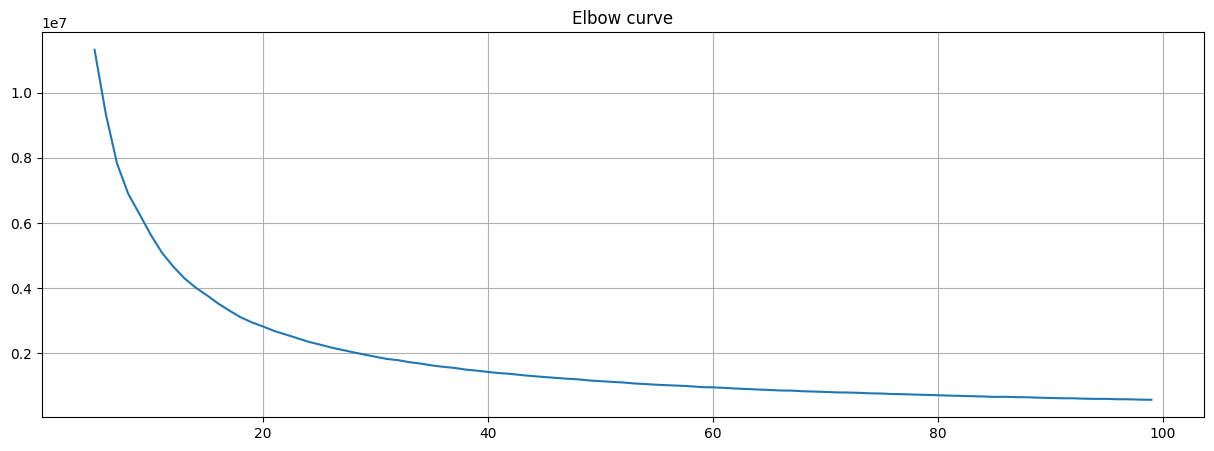

In [ ]:
vals = []
for k in range(5, 100):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsne)
    vals.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(5, 100), vals)
plt.grid(True)
plt.title('Elbow curve')

Testando novamente com um número reduzido de clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0.5, 1.0, 'Elbow curve')

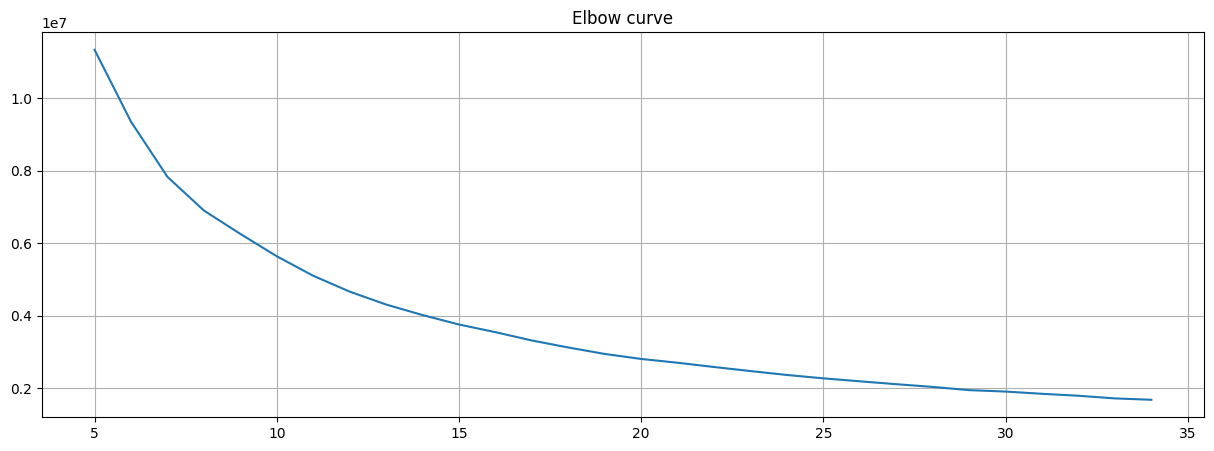

In [ ]:
vals = []
for k in range(5, 35):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsne)
    vals.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(5, 35), vals)
plt.grid(True)
plt.title('Elbow curve')

Usamos o método de `Silhouette Score` para entender o ganho de informação de um cluster para outro. Notamos que 6 clusters tem o maior ganho de informação. Todavia, 6 cluster é um número muito pequeno para generalizar 26 categorias de restaurante. Por isso, iremos usar os scores de cada cluster para avaliá-los de outra forma abaixo.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

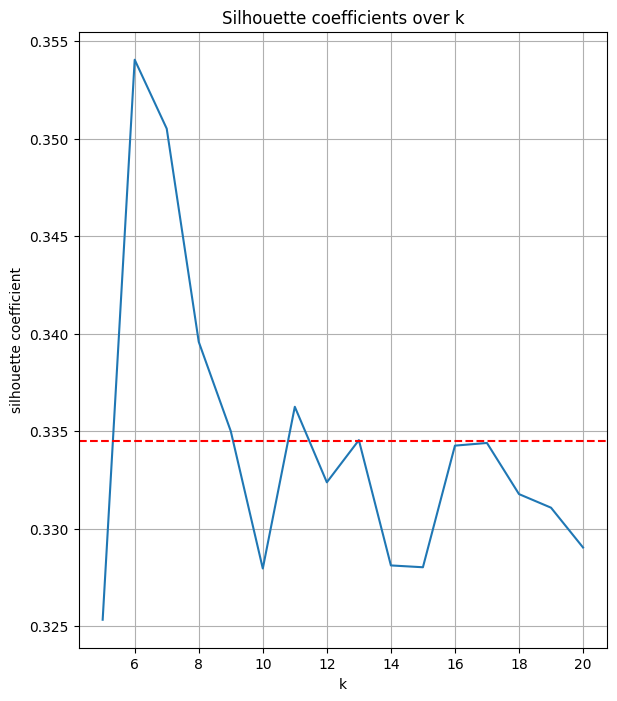

In [ ]:
silhouette_plot = []
for k in range(5, 21):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(tsne)
    silhouette_avg =silhouette_score(tsne, cluster_labels)
    silhouette_plot.append(silhouette_avg)
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(5, 21), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [ ]:
silhouette_plot

[0.32533646,
 0.35403752,
 0.35050485,
 0.33957767,
 0.3350015,
 0.32796142,
 0.3362499,
 0.3323792,
 0.33454072,
 0.3281192,
 0.32802537,
 0.33425912,
 0.3343954,
 0.33177504,
 0.33107838,
 0.32903805]

#### Modelagem KMeans para 16 clusters

In [ ]:
km= KMeans(n_clusters=16, random_state=42).fit(tsne)
cluster = km.labels_
centroids = km.cluster_centers_
score = silhouette_score(tsne, km.labels_, metric='euclidean')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


O score da silhueta varia de -1 a 1. `1` sendo que o cluster foi "corretamente" associado ao seu devido cluster, `0` significa que ele está muito próximo a outro cluster e `-1` significa que ele foi "incorretamente" associado. Nosso score, com K=16, é de 0.33. Acima de 0, mas abaixo de -1(O que é impossível de ser atingido). 

In [ ]:
score

0.33266073

#### Visualização de como os 16 clusters estão dispersos em 2-D com TSNE

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


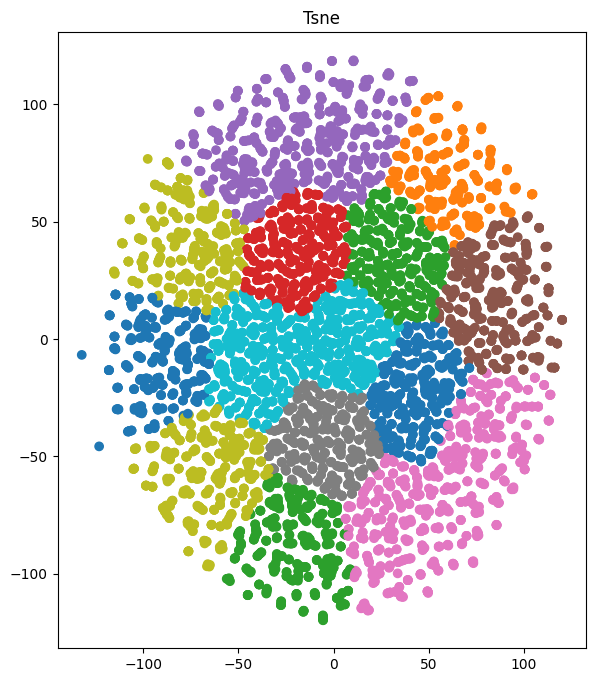

In [ ]:
km_neat = KMeans(n_clusters=16, random_state=42).fit_predict(tsne)
cmap = 'tab10'
plt.figure(figsize=(15,8))
plt.subplot(121, title='Tsne')
plt.scatter(tsne[:,0], tsne[:,1], c=km_neat, cmap=cmap)

## Agrupamento Hierárquico
Acabou não se tornando o modelo mais ideal para nossa segmentação. Ele generaliza mais, como podem ver abaixo no dendograma. Em teoria, a altura maior do dendograma definiria o número de clusters ideais para nosso modelo. Todavia, essa linha sempre se mostra inferior a 8. Como mencionamos antes, é um número baixo para nossa segmentação. Caso fossemos usar esse algoritmo, teríamos que escolher alturas menores.

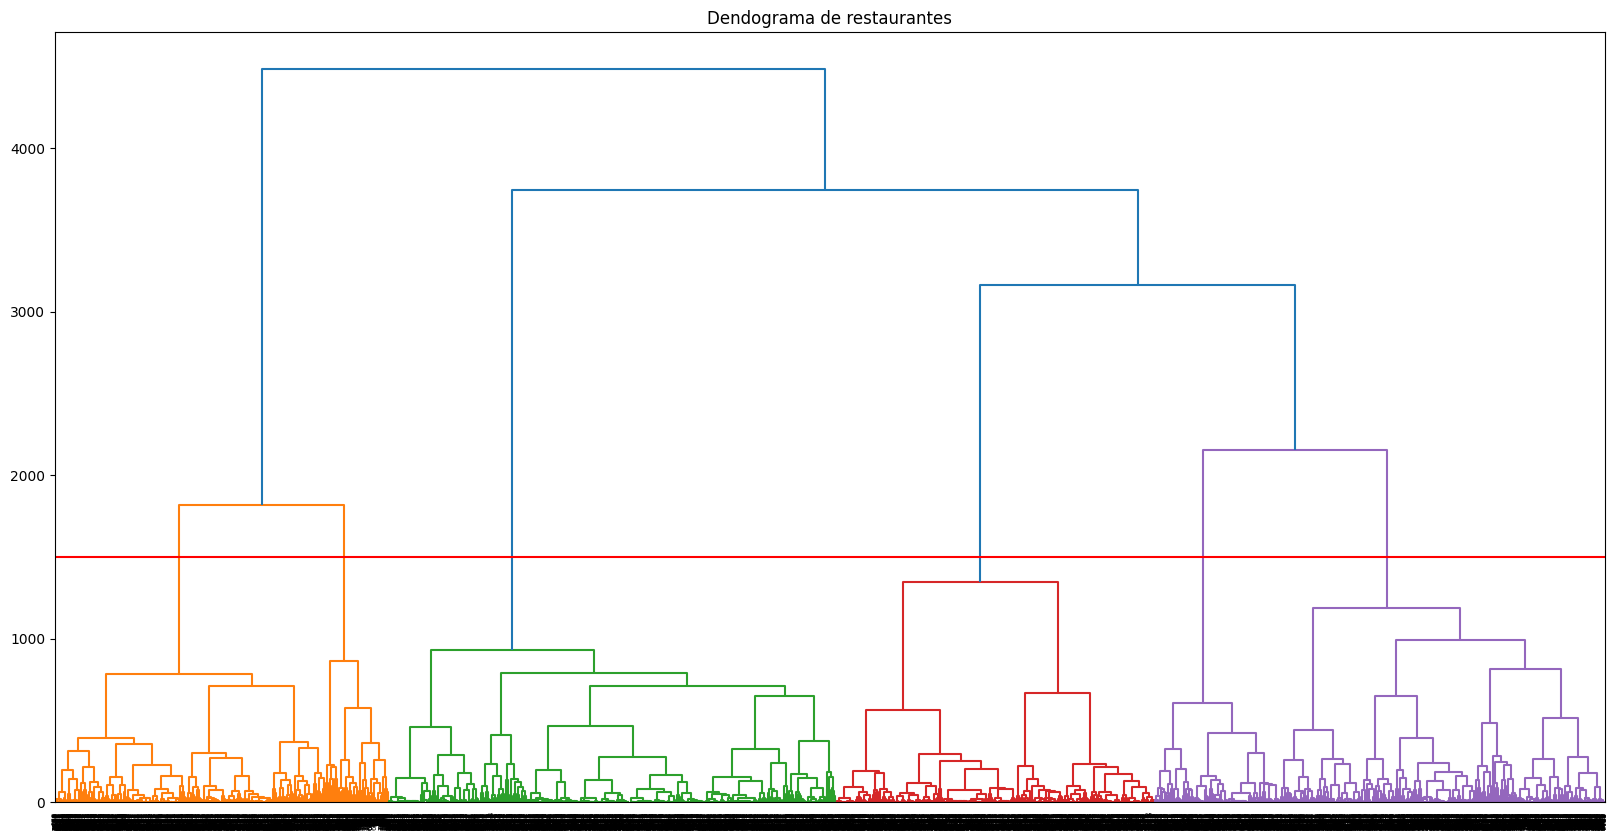

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Dendograma de restaurantes")
clusters = shc.linkage(df_modelo, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 1500, color = 'r', linestyle = '-')
#6 ou 7

## Análise pós primeira modelagem
Adicionando o label e o nome do restaurante dos clusters ao dataframe do modelo.

In [ ]:
df_modelo['Cluster'] = cluster
#pegar o cluster e adicionar a base
#adicionar o nome do lugar para entender a qual cluster cada um foi colcoado
df_modelo['Nome_Restaurante'] = df5['title_x']
df_modelo['place_id'] = df5['place_id']

#### Analisando resultados

In [ ]:
cluster = df_modelo.loc[df_modelo['Cluster'] == 5]
cluster

,rating,price,inicio,fim,aberto_dia_util(%),aberto_final_de_semana(%),madrugada,manha,tarde,noite,dine_in,takeout,delivery,drive_through,freq,mean_price_zona,mean_review_type,type_bakery,type_bar,type_barbecue restaurant,type_brazilian restaurant,type_buffet restaurant,type_candy store,type_coffee shop,type_fast food restaurant,type_french restaurant,type_health food restaurant,type_ice cream shop,type_italian restaurant,type_japanese restaurant,type_juice shop,type_korean restaurant,type_mexican restaurant,type_middle eastern restaurant,type_night club,type_pizza restaurant,type_portuguese restaurant,type_restaurant,type_seafood restaurant,inicio_periodo_madrugada,inicio_periodo_manha,inicio_periodo_tarde,fim_periodo_madrugada,fim_periodo_manha,fim_periodo_noite,fim_periodo_tarde,ZonaSP_Centro,ZonaSP_Leste,ZonaSP_Norte,ZonaSP_Oeste,ZonaSP_Outro,ZonaSP_Sul,Cluster,Nome_Restaurante,place_id
1,4.6,5,11.500000,14.500000,100.0,66.7,0.0,7.0,36.0,0.0,1,1,1,0,0.217361,0.385980,0.163770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,5,2 L's Restaurante E Bar Almoço-Lanches,ChIJU4W1hWVezpQRb7UZOCXHQNk
16,4.5,5,6.016667,6.016667,100.0,100.0,0.0,0.0,0.0,0.0,1,1,1,0,0.217361,0.410528,0.163770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,5,R&S Pastelaria E Lanchonete Servimos Almoço,ChIJMUjhG1ZFzpQRn4MX_kSIyv8
63,4.4,0,11.000000,16.000000,100.0,66.7,0.0,15.0,58.0,0.0,1,1,0,0,0.056067,0.348082,0.161898,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,5,Restaurante Puro Sabor de Ipanema,ChIJOWpmNwXVmwARAerbOcgrZLE
70,4.4,0,11.000000,15.500000,100.0,66.7,0.0,15.0,51.0,0.0,1,1,0,0,0.032466,0.348082,0.149808,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,5,Restaurante Bom de Garfo,ChIJ5y4kLmwDzpQRmWL0QjyMpWA
76,4.7,1,11.500000,14.500000,75.0,66.7,0.0,7.0,36.0,0.0,1,1,0,0,0.024752,0.407516,0.188677,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,5,Mugui,ChIJZW9ooKlZzpQRpE2_1q2Udcs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,4.1,0,9.000000,18.500000,100.0,66.7,0.0,49.0,94.0,0.0,0,1,1,0,0.088073,0.462910,0.157473,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,5,Casa de Bolos,ChIJ35aPu3z3zpQRjltH6efspJ8
8560,4.5,0,11.000000,16.000000,100.0,66.7,0.0,15.0,58.0,0.0,1,1,0,0,0.056067,0.425406,0.161898,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,5,Toca Restaurante,ChIJSXfls0j4zpQRdEdaJ6Hqpwo
8612,4.9,5,11.750000,15.000000,75.0,66.7,0.0,3.0,43.0,0.0,1,1,0,0,0.117430,0.425406,0.282002,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,5,Pedroas Hamburgueria- Freguesia Do Ó,ChIJEzKXhMT5zpQRrfNE9e7i85w
8625,4.6,5,10.000000,12.000000,100.0,66.7,0.0,32.0,0.0,0.0,1,1,0,0,0.140226,0.425406,0.146584,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,5,Almeida's Bar,ChIJPecMkK35zpQRCnp1lY9d8Yg


In [ ]:
result = df_modelo.groupby('Cluster').agg({'rating':'mean','dine_in':'sum', 'takeout':'sum', 'delivery':'sum',
       'drive_through':'sum', 'type_bakery':'sum', 'type_bar':'sum', 'type_barbecue restaurant':'sum',
       'type_brazilian restaurant':'sum', 'type_buffet restaurant':'sum',
       'type_candy store':'sum', 'type_coffee shop':'sum', 'type_fast food restaurant':'sum',
       'type_french restaurant':'sum', 'type_health food restaurant':'sum',
       'type_ice cream shop':'sum', 'type_italian restaurant':'sum',
       'type_japanese restaurant':'sum', 'type_juice shop':'sum', 'type_korean restaurant':'sum',
       'type_mexican restaurant':'sum', 'type_middle eastern restaurant':'sum',
       'type_night club':'sum','type_pizza restaurant':'sum','type_portuguese restaurant':'sum',
        'type_restaurant':'sum','type_seafood restaurant':'sum','inicio_periodo_madrugada':'sum',
        'inicio_periodo_manha':'sum', 'inicio_periodo_tarde':'sum',
        'fim_periodo_madrugada':'sum', 'fim_periodo_manha':'sum','fim_periodo_tarde':'sum',
        'fim_periodo_noite':'sum'})
result

,rating,dine_in,takeout,delivery,drive_through,type_bakery,type_bar,type_barbecue restaurant,type_brazilian restaurant,type_buffet restaurant,type_candy store,type_coffee shop,type_fast food restaurant,type_french restaurant,type_health food restaurant,type_ice cream shop,type_italian restaurant,type_japanese restaurant,type_juice shop,type_korean restaurant,type_mexican restaurant,type_middle eastern restaurant,type_night club,type_pizza restaurant,type_portuguese restaurant,type_restaurant,type_seafood restaurant,inicio_periodo_madrugada,inicio_periodo_manha,inicio_periodo_tarde,fim_periodo_madrugada,fim_periodo_manha,fim_periodo_tarde,fim_periodo_noite
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.379837,407,353,80,33,51,69,17,21,28,12,2,69,3,11,5,14,9,9,2,4,2,4,20,1,75,1,0,286,135,60,7,85,277
1,4.420982,529,465,82,18,25,87,38,37,16,13,3,54,6,16,29,28,13,8,3,2,12,8,31,0,123,8,0,349,196,114,7,132,307
2,4.416627,392,358,66,5,11,74,21,17,15,2,0,42,5,13,19,27,12,0,0,7,4,13,52,2,80,5,0,174,203,42,5,127,247
3,4.469459,461,402,99,10,79,103,28,27,11,16,2,47,6,15,15,18,4,5,0,3,7,40,16,0,107,6,0,327,140,95,17,117,326
4,4.425107,431,413,75,6,35,66,16,22,5,18,4,47,7,8,21,19,16,3,5,2,6,2,74,3,87,2,3,198,262,31,0,53,384
5,4.497935,528,509,105,5,57,44,38,27,33,22,3,55,2,24,14,22,22,11,7,4,12,6,39,5,132,2,1,399,160,17,5,280,279
6,4.412143,380,360,74,15,41,39,27,20,19,13,3,78,3,17,27,9,12,6,2,10,4,5,18,0,63,4,0,328,78,3,1,164,251
7,4.373161,473,406,75,40,33,110,12,44,22,9,1,77,3,7,7,7,2,6,0,4,7,15,24,1,112,0,3,420,51,153,8,134,208
8,4.408627,554,528,48,8,9,87,38,47,16,4,1,64,7,6,9,41,43,3,1,10,13,7,41,7,109,5,4,320,240,88,5,213,262


In [ ]:
#Adicionando de volta as colunas para colocar no dashboard completo
df_modelo['type'] = df5['type']
df_modelo['address'] = df5['address']
df_modelo['latitute'] = df5['latitude']
df_modelo['longitude'] = df5['longitude']

In [ ]:
# #Caso formos fazer uma pipeline e depois salver
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline
# steps = [('scaler', StandardScaler()),
#          ('tsne', TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)),
#          ('clustering', KMeans())]
# pipeline = Pipeline(steps)
# import joblib
# joblib.dump(pipeline, 'my_pipeline.joblib')
# new_data = pd.read_csv('nome_novos_dados_se_tiver.csv',index_col=0)
# loaded_pipeline = joblib.load('my_pipeline.joblib')
# predicted_cluster = loaded_pipeline.predict(new_data)

In [ ]:
df_geral_db = df5[['title', 'place_id', 'rating', 'reviews',
       'price', 'type', 'ZonaSP', 'address', 'latitude', 'longitude', 'open_state',
       'description', 'thumbnail', 'sunday', 'monday', 'tuesday',
       'wednesday', 'thursday', 'friday', 'saturday', 'inicio', 'fim',
       'aberto_dia_util(%)', 'aberto_final_de_semana(%)', 'madrugada', 'manha',
       'tarde', 'noite', 'inicio_periodo', 'fim_periodo', 'dine_in',
       'takeout', 'delivery', 'drive_through']]

df_geral_db = df_geral_db.merge(df_modelo[['place_id',  'Cluster']], how='left', on='place_id' )

In [ ]:
df_geral_db.to_csv('df_geral_db.csv', index=False)